In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Manejo de datasets

Es posible que para un problema de muchas variables, o con muchos datos, 
no sea posible cargar todo el dataset y el modelo en memoria, por lo que se deberá trabajar por lotes (batches). 
PyToch provee una herramienta muy útil para manejar datasets grandes.

Estas herramientas son las clases Dataset y Dataloader.

## La clase Dataset debe heredar de la clase madre torch.utils.data.Dataset, y debe tener definidos:

* el constructor: \_\_init\_\_()
* el metodo \_\_len\_\_(): que dice cuantos elementos tiene el dataset
* el metodo \_\_getitem\_\_(idx): proporciona a partir de un indice (idx) el elemento correspondiente

Veremos un ejemplo concreto para un dataset creado a partir de arrays de numpy

In [3]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        '''Cuando solamente tenemos que leer dos arrays de numpy, el constructor es muy simple'''
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Clase Dataloader

Esta clase crea los iteradores necesarios para trabajar por batches, la implementacion es muy simple, basta pasarle el dataloader
```
torch.utils.data.DataLoader(dataset_object, batch_size= 64, shuffle=True)
```

Una vez que se tienen los dataloaders es conveniente realizar funciones o clases para entrenar y evaluar el modelo.

Veamos todo esto en un ejemplo simple

### **Analisis del dataset del SMN**

In [4]:
import csv, os, sys
import datetime
# necesitamos setear el path como variable de entorno para importar modulos
sys.path.append(os.path.join('..','..','libs'))
from read_smn import read_smn

In [5]:
lector = read_smn(os.path.join('..','..','Data','junio-SMN','horario'))
# veamos algun dato
lector.data_fmttd[297]

{'timestamp': datetime.datetime(2023, 6, 14, 18, 0),
 'temp': 14.3,
 'hum': 30.0,
 'pres': 1023.7,
 'v_direcc': 70.0,
 'v_intens': 7.0,
 'estac': 'CHAMICAL AERO'}

In [6]:
# Extraemos los datos de salta
tstamps, data = lector.filter_by_station('SALTA')

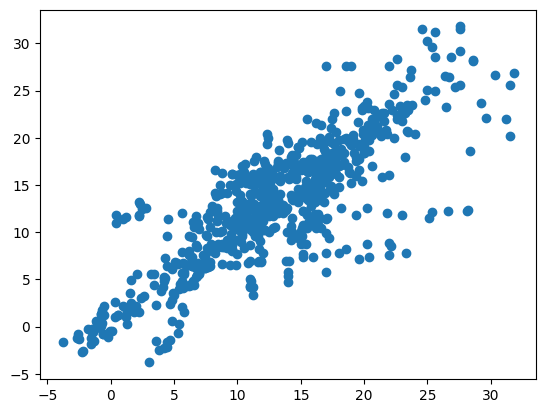

In [8]:
# un plot para ver mejor (asumiendo un delay de 24 horas)
plt.scatter(data[:-24,0], data[24:,0])

In [ ]:
# En la libreria Libs, el modulo prediction_models tiene definidos 
# dos modelos, el modelo naive, y el modelo delayed naive
import prediction_models as pm

In [ ]:
print(data[:10,0])
print(f'Naive: {pm.naive(data[:10,0])}')

[11.8 11.   9.4  9.9  9.9 10.2 10.4 10.4 10.   9.6]
Naive: 9.6


Para comenzar vamos a trabajar con una columna (Close).

Vamos a crear ventanas de datos para predecir el dato siguiente, por ejemplo dados 10 datos, predeciremos el 11vo

In [ ]:
def create_training(X, lookback):
    x = []
    y = []
    for i in range(len(X)-lookback-1):
        x.append(X[i:i+lookback])
        y.append(X[i+lookback+1])
    return np.array(x), np.array(y)

In [ ]:
# Hacemos todos los conjuntos de entrenamientos posibles
lookback = 50
x_train, y_train = create_training(train_values[:,3],lookback)
x_test, y_test = create_training(test_values[:,3],lookback)

# creamos los datasets y dataloaders en un diccionario para manejar mas simple
dataset = {'train': Dataset(x_train, y_train),
           'test' : Dataset(x_test, y_test)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 64, shuffle= True),
            'test' : torch.utils.data.DataLoader(dataset['test'], batch_size = 32, shuffle= True)}

In [ ]:
# creamos un perceptron multicapa sencillito

class MLP(torch.nn.Module):
    # constructor
    def __init__(self, n_inputs, n_hidden, n_out) -> None:
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(n_inputs, n_hidden)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n_hidden, n_out)

    # paso forward
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return(x.view(-1))

In [ ]:
mlp_net = MLP(lookback, 64, 1)
print(mlp_net)
print('numero de parametros:')
print('linear1: ', mlp_net.linear1.weight.shape, mlp_net.linear1.bias.shape)
print('linear2: ', mlp_net.linear2.weight.shape, mlp_net.linear2.bias.shape)

MLP(
  (linear1): Linear(in_features=50, out_features=64, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)
numero de parametros:
linear1:  torch.Size([64, 50]) torch.Size([64])
linear2:  torch.Size([1, 64]) torch.Size([1])


In [ ]:
# veamos que entrega el modelo y el dataloader
print(mlp_net(torch.ones(32,lookback)).shape)
print(next(iter(dataloader['train']))[1].shape)

torch.Size([32])
torch.Size([64])


In [ ]:
# como siempre se sigue una manera similar de entrenamiento, 
# conviene definir una funcion... 
# ... si se escribe muchas veces lo mismo es porque algo estamos haciendo mal

def fit(model, dataloader, epochs = 10):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrera por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        model.eval() # no estamos entrenando
        test_h = [] 
        with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
            for x_b, y_b in dataloader['test']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                test_h.append(loss.item())
        print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h)} - test loss: {np.mean(test_h)}')                
        history.append([np.mean(train_h), np.mean(test_h)])
    return history



In [ ]:
hist = fit(mlp_net, dataloader, epochs=20)
print('----------------------------------------------')
print(f'train loss: {hist[-1][0]} - test loss: {hist[-1][1]}')
print('----------------------------------------------')

epoch: 1/20 - train loss: 139.78798363255518 - test loss: 78.04504903157552
epoch: 2/20 - train loss: 17.12549196505079 - test loss: 79.26553344726562
epoch: 3/20 - train loss: 15.935187723122391 - test loss: 80.87766520182292
epoch: 4/20 - train loss: 15.068782189313103 - test loss: 92.22000122070312
epoch: 5/20 - train loss: 14.43659932940614 - test loss: 34.33340962727865
epoch: 6/20 - train loss: 13.382239734425264 - test loss: 60.61568832397461
epoch: 7/20 - train loss: 12.089436236549826 - test loss: 42.11634953816732
epoch: 8/20 - train loss: 11.244417686088413 - test loss: 40.15131632486979
epoch: 9/20 - train loss: 10.514484386818081 - test loss: 32.35707473754883
epoch: 10/20 - train loss: 9.761526729546341 - test loss: 38.329976399739586
epoch: 11/20 - train loss: 8.778487962834975 - test loss: 33.175001780192055
epoch: 12/20 - train loss: 8.093599067014807 - test loss: 25.89712651570638
epoch: 13/20 - train loss: 8.302119844100055 - test loss: 33.19609133402506
epoch: 14/20

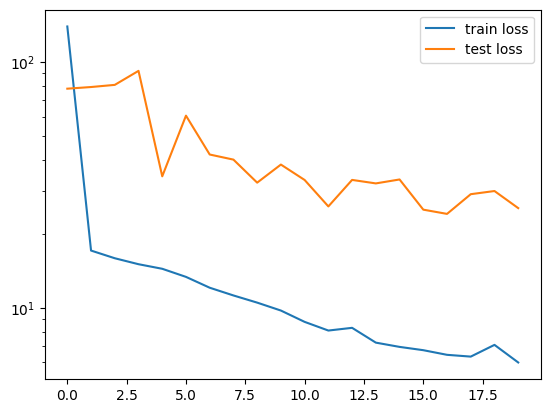

In [ ]:
plt.semilogy([h[0] for h in hist], label= 'train loss')
plt.semilogy([h[1] for h in hist], label= 'test loss')
plt.legend()
plt.show()

In [ ]:
data_plot = next(iter(dataloader['test']))
x_plot, y_true = data_plot[0].detach().numpy(), data_plot[1].detach().numpy()
y_pred = mlp_net(data_plot[0]).detach().numpy()
print(x_plot.shape, y_true.shape, y_pred.shape)

(32, 50) (32,) (32,)


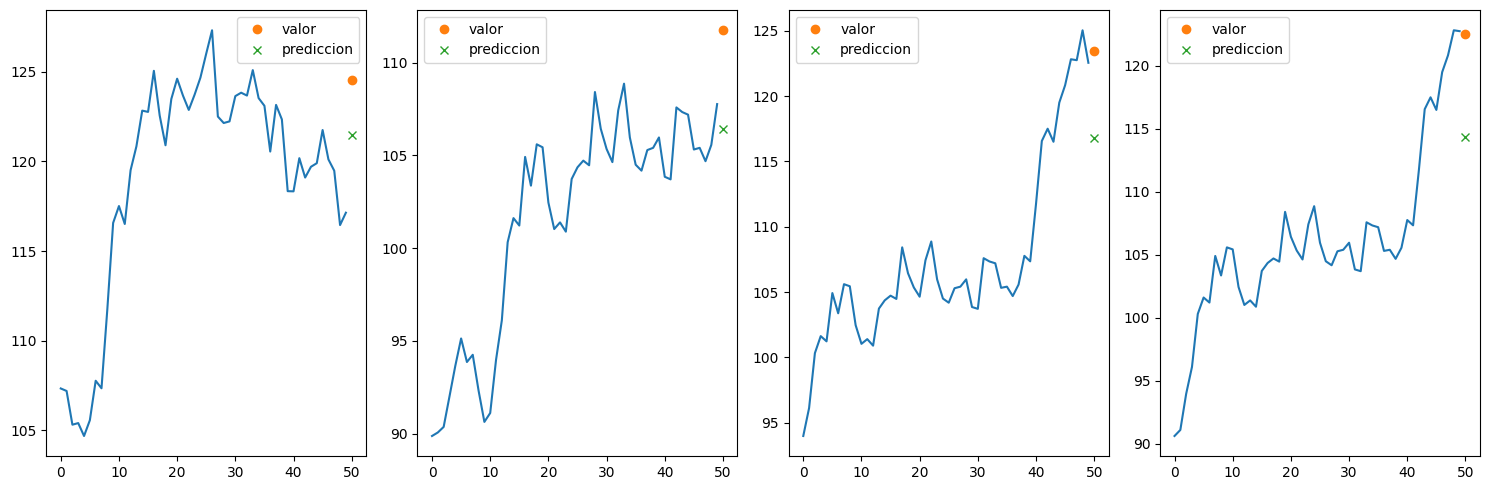

In [ ]:
pidx = np.random.randint(0,32,4)
fig, axs = plt.subplots(1,4, figsize=(15,5))
for i in range(4):
    axs[i].plot(x_plot[pidx[i]])
    axs[i].plot(lookback, y_true[pidx[i]], 'o', label = 'valor')
    axs[i].plot(lookback, y_pred[pidx[i]],'x', label = 'prediccion')
    axs[i].legend()
fig.tight_layout()
plt.show()

In [ ]:
# Para las redes neuronales es mas simple ajustarse si los datos estan escalados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(numerical_features)

x_train, y_train = create_features(features_scaled[:-100], m =1, w = 12, delay=1)
x_test, y_test = create_features(features_scaled[-100:], m =1, w = 12, delay=1)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
len(dataset_train)

NameError: name 'StandardScaler' is not defined

In [ ]:
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn


import sys
if sys.path[0].endswith('src'):
    from process_dataset import load_dataset
else:
    from src.process_dataset import load_dataset

# model
class Neural(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Neural, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Linear(hidden_size//4, output_size)
        )
    def forward(self, x):
        return self.layers(x)

class trainer_tester:
    def __init__(self, configs) -> None:

        self.configs = configs
        self.batch_size = self.configs['data_load']['batch_size']
        if self.configs['train']['history']:
            self.history = {}
            self.history['train_loss'] = []
            self.history['test_loss'] = []
        # model creation
        if self.configs['data_load']['extraction_method'] == 'peaks':
            self.configs['model']['input_size'] = 2*self.configs['model']['input_size']
        self.model = Neural(
                        self.configs['model']['input_size'],
                        self.configs['model']['hidden_size'], 
                        self.configs['model']['output_size']
                        )
        # Optimizer setup
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
                    self.model.parameters(), 
                    lr=self.configs['optimizer']['learning_rate']
                    )

    def fit_train_test(self):
        self.data_load_stage()
        self.training_stage()
        self.test_evaluation()
        print('[+] Check self.relative_errors to calculate the accuracy'+ 
               ' over the test set')


    def data_load_stage(self):
        self.dataset_train = load_dataset(
                    self.configs['data_load']['data_folder'], 
                    n_window = self.configs['data_load']['n_window'], 
                    extraction_method = self.configs['data_load']['extraction_method'], 
                    test_size = self.configs['data_load']['test_size'], 
                    test = False
                    )
        self.dataloader_train = DataLoader(
                    self.dataset_train, 
                    batch_size = self.batch_size,
                    shuffle = True, 
                    num_workers=2
                    )
        self.dataset_test = load_dataset(
                    self.configs['data_load']['data_folder'], 
                    n_window = self.configs['data_load']['n_window'], 
                    extraction_method = self.configs['data_load']['extraction_method'], 
                    test_size = self.configs['data_load']['test_size'], 
                    test = True
                    )
        self.dataloader_test = DataLoader(
                    self.dataset_test, 
                    batch_size= self.batch_size, 
                    shuffle=True
                    )

    def training_stage(self):
        self.n_samples_trn = len(self.dataset_train)
        self.n_iterations_trn = np.ceil(self.n_samples_trn/self.batch_size).astype(np.int32)

        for epoch in range(self.configs['train']['epochs']):
            for i, (self.X,self.Y) in enumerate(self.dataloader_train):
                # forward pass
                self.outputs = self.model(self.X)
                self.loss = self.criterion(self.outputs, self.Y)
                # backward pass
                self.optimizer.zero_grad()
                self.loss.backward()
                self.optimizer.step() 
                if (i+1) % (self.n_iterations_trn//5 +1 ) == 0:
                    print(f"Epoch: {epoch+1}/{self.configs['train']['epochs']}, iter: {i+1}/{self.n_iterations_trn}. Loss = {self.loss.item()}")
                if self.configs['train']['history']:
                    self.history['train_loss'].append(self.loss.item())

    def test_evaluation(self):
        self.n_samples_tst = len(self.dataset_train)
        self.n_iterations_tst = np.ceil(self.n_samples_tst/self.batch_size).astype(np.int32)
        self.relative_errors = np.empty(1)
        with torch.no_grad():
            for i, (self.X,self.Y) in enumerate(self.dataloader_test):
                # forward pass
                self.outputs = self.model(self.X)
                self.loss = self.criterion(self.outputs,self.Y)
  
                if (i+1) % (self.n_iterations_tst//5 +1 ) == 0:
                    print(f"Iter: {i+1}/{self.n_iterations_tst}. Loss = {self.loss.item()}")
                if self.configs['train']['history']:
                    self.history['test_loss'].append(self.loss.item())
                err = (self.outputs.numpy().flatten() - self.Y.numpy().flatten())/self.Y.numpy().flatten()
                self.relative_errors = np.hstack([self.relative_errors,err])
            self.relative_errors = self.relative_errors[1:]

    def save_model(self, folder='models', filename='model.pth'):
        destination = os.path.join(os.getcwd(), folder)
        if os.path.isdir(destination):
            print(f'[+] model will be saved at: {destination}')
            destination = os.path.join(destination, filename)
            torch.save(obj=self.model.state_dict(),
                f=destination)
            print(f'[+] Done!')
        else:
            print(f'[!!] Directory not found: {destination}')


    def load_model(self, folder='models', filename='model.pth'):
        destination = os.path.join(os.getcwd(), folder)
        if os.path.isdir(destination):
            print(f'[+] model {filename} will be loaded from: {destination}')
            destination = os.path.join(destination, filename)
            self.model.load_state_dict(torch.load(f = destination))
            print(f'[+] Done!')
        else:
            print(f'[!!] Directory not found: {destination}')


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    coso = trainer_tester(configs=trainer_config)
    coso.fit_train_test()
    print('--------------------------------------------------')
    print(f"Method: {coso.configs['data_load']['extraction_method']}")
    print(f"Mean relative error: {np.abs(coso.relative_errors).mean():.5f}")
    print(f"STD relative error: {coso.relative_errors.std():.5f}")
    title = 'Method: ' + coso.configs['data_load']['extraction_method'] +'\n' 
    title += '\n Window size:' + str(coso.configs['data_load']['n_window'])
    title += ' Epochs: '
    title += str(coso.configs['train']['epochs'])
    plt.figure(figsize=(15,6))
    plt.suptitle(title)
    plt.loglog(coso.history['train_loss'], 'bo', label='Training loss')
    plt.loglog(coso.history['test_loss'], 'ro', label = 'Test Losses')
    plt.legend()
    plt.show()
    plt.figure(figsize=(15,6))
    title = 'Relative errors over test set: \n'
    title += ' relative error: mean = '
    title += str(round(np.abs(coso.relative_errors).mean(),4))
    title += ' std = '
    title += str(round(coso.relative_errors.std(),4))
    plt.title(title)
    plt.semilogy(coso.relative_errors, 'bo')
    plt.show()
    coso.save_model(folder='models', filename='dummy.pth')
    print(f'Saved!')
    coso.load_model(folder='models', filename='dummy.pth')

ModuleNotFoundError: No module named 'src'